In [226]:
import numpy as np
import pandas as pd
from pylab import plt
import ProfundaEnv as prfenv

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.6f}'.format

In [2]:
#Download and preprocess the data
symbols = ['AUD_CAD', 'BCO_USD'] # Used currency pair
env = prfenv.ProfundaEnv(symbols = symbols,target = 'AUD_CAD', start_date = '2021-12-20 00:00:00', end_date = '2023-12-20 00:00:00', freq='M5')

File exists
Downloaded: AUD_CAD_2021_12_20_00_00_00_2023_12_20_00_00_00_M5.csv
                     AUD_CAD  AUD_CAD_vol
time                                     
2021-12-20 00:00:00 0.918480          352
2021-12-20 00:05:00 0.918360          297
2021-12-20 00:10:00 0.918500          342
2021-12-20 00:15:00 0.918260          273
2021-12-20 00:20:00 0.918300          209
File exists
Downloaded: BCO_USD_2021_12_20_00_00_00_2023_12_20_00_00_00_M5.csv
                      BCO_USD  BCO_USD_vol
time                                      
2021-12-20 01:00:00 72.420000          422
2021-12-20 01:05:00 72.543000          615
2021-12-20 01:10:00 72.706000          463
2021-12-20 01:15:00 72.418000          381
2021-12-20 01:20:00 72.342000          325
date
return
Index(['AUD_CAD', 'AUD_CAD_vol', 'BCO_USD', 'BCO_USD_vol', 'year', 'month',
       'day', 'hour', 'minute', 'second', 'day_of_week', 'return',
       'rev_return', 't_up', 't_zero', 't_down'],
      dtype='object')
roll_mean
roll_std
m

Training data consist of 2 years and 1 year of testing

<AxesSubplot:xlabel='time'>

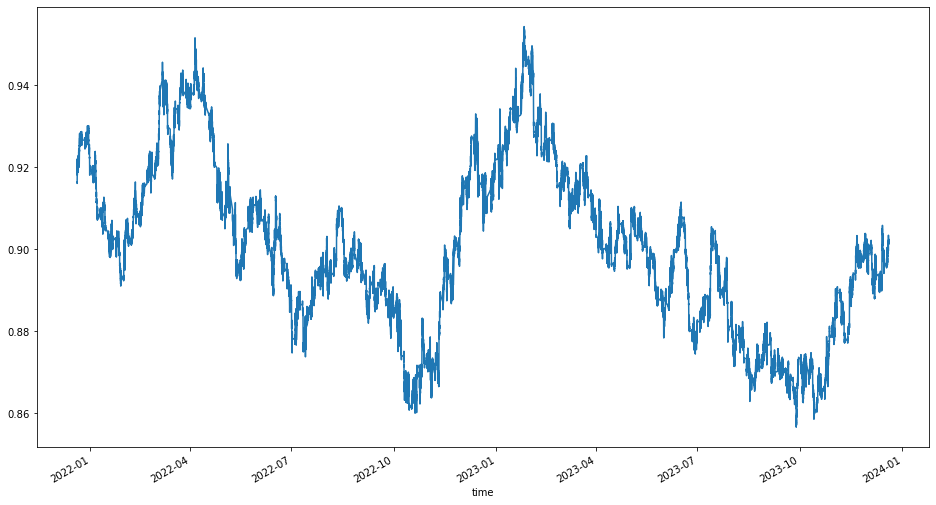

In [106]:
#Chart of the data
env.data['AUD_CAD'].plot(figsize=(16,9))

In [227]:
strategy_data =  pd.DataFrame(env.data.copy())
strategy_data['ewma1'] =  strategy_data['AUD_CAD'].ewm(span=42, adjust=False).mean()
strategy_data['ewma2'] =  strategy_data['AUD_CAD'].ewm(span=258, adjust=False).mean()

strategy_data.dropna(inplace=True)

<AxesSubplot:xlabel='time'>

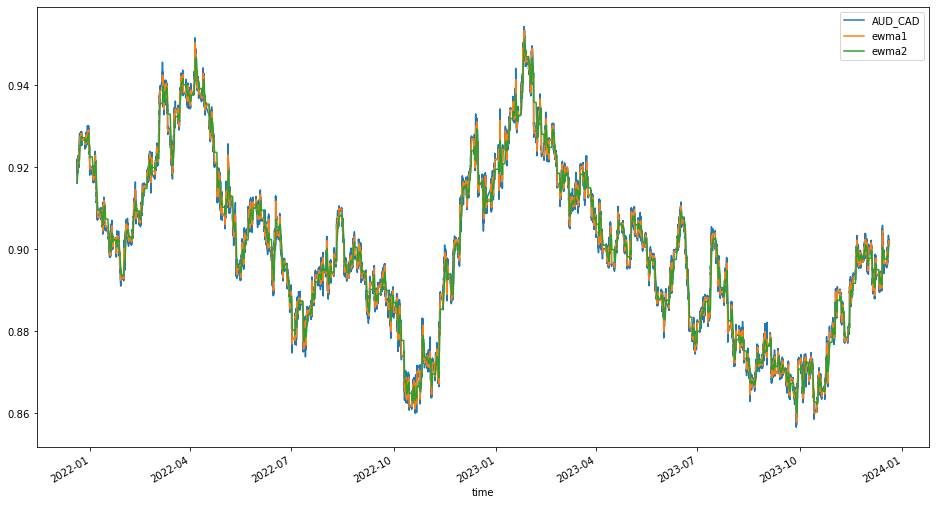

In [228]:
strategy_data[ ['AUD_CAD', 'ewma1', 'ewma2' ] ].plot(figsize=(16,9))

In [245]:
#When short moving average is above long short moving average buy otherwise sell
strategy_data['p'] = np.where(strategy_data['ewma1'] > strategy_data['ewma2'], 1, -1)

strategy_data['p'] = strategy_data['p'].shift(1) #For getting rid of data peeking 
strategy_data.dropna(inplace=True)

<AxesSubplot:xlabel='time'>

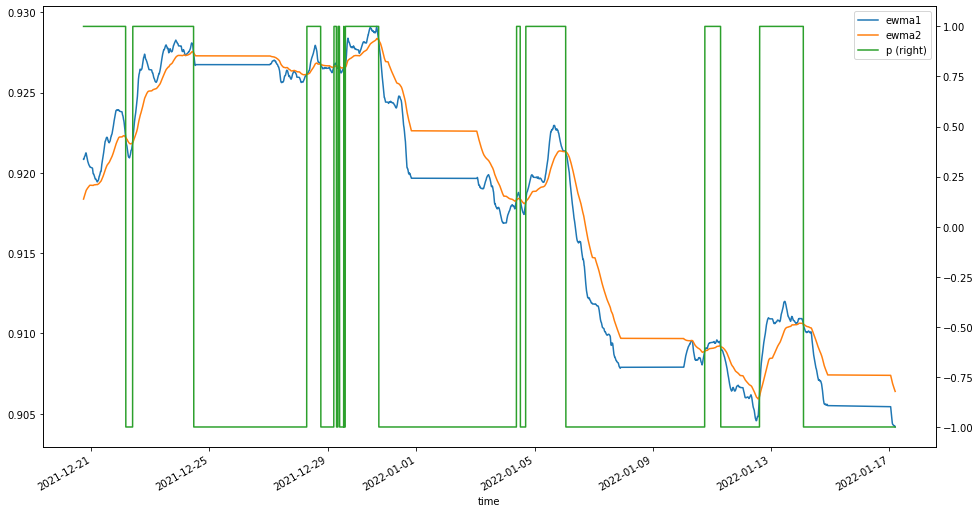

In [246]:
strategy_data[100:5000][ ['ewma1', 'ewma2', 'p'] ].plot(figsize=(16, 9), secondary_y='p')

In [249]:
#Profit/ loss calculation
strategy_data['ret'] = np.log(strategy_data['AUD_CAD'] / strategy_data['AUD_CAD'].shift(1))
strategy_data.dropna(inplace=True)

strategy_data['pos_val'] = strategy_data['p'] * strategy_data['ret'] # Obliczanie stopy zwrortu Logm returns

#spread = 0.005
#trans_cost = spread / open_data['AUD_CAD'].mean()
trans_cost = 0.00012
strategy_data['pos_val_'] = np.where(strategy_data['p'].diff() != 0, strategy_data['pos_val'] - trans_cost, strategy_data['pos_val'])

#Cost for opening position
strategy_data['pos_val_'].iloc[0]  -= trans_cost

#Cost for closing opening position
strategy_data['pos_val_'].iloc[-1] -= trans_cost

strategy_data[['ret', 'pos_val','pos_val_']].sum().apply(np.exp) 

sum_of_trades = len(strategy_data[strategy_data['p'].diff() != 0])

print('Return of pair AUD_CAD(full data): ', "%.6f" % strategy_data[['ret']].sum().apply(np.exp)[0])
print('Return of strategy(full data): ', "%.6f" % strategy_data[['pos_val']].sum().apply(np.exp)[0])
print('Return of strategy after transaction costs(full data): ', "%.6f" % strategy_data[['pos_val_']].sum().apply(np.exp)[0])
print("Sum of trades: ", sum_of_trades)

Return of pair AUD_CAD(full data):  0.983852
Return of strategy(full data):  0.938919
Return of strategy after transaction costs(full data):  0.852463
Sum of trades:  803


<AxesSubplot:xlabel='time'>

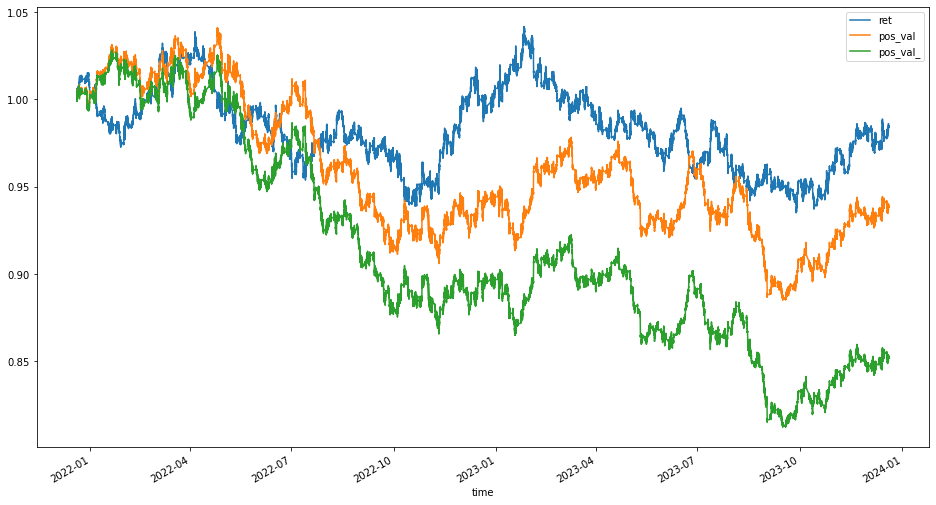

In [131]:
strategy_data[['ret', 'pos_val','pos_val_']].cumsum().apply(np.exp).plot(figsize=(16,9))    # gross performance

Sharpe Ratio (full data): 0.990002155996815
Calmar Ratio (full data): -5.457712186124138e-06
Longest drawdown period (full data):  15 days, 20:45:00
Maximum drawdown (full data):  21.62 %


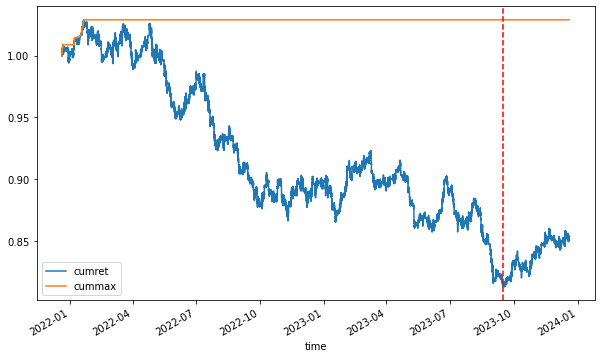

In [250]:
# Assuming df is your DataFrame with column 'log_ret'
# Replace 'df' and 'log_ret' with your actual DataFrame and column name if different

# Step 1: Calculate mean and standard deviation of log returns

#mean_log_ret = open_data['pos_val_'].mean()

mean_ret = strategy_data[['pos_val_']].mean().apply(np.exp)
std_ret =  strategy_data[['pos_val_']].std().apply(np.exp)

# Step 2: Calculate Sharpe ratio
#trading_days_per_year = 252  # Assuming daily data
risk_free_rate = 0.01
sharpe_ratio = (mean_ret - risk_free_rate /  std_ret)[0]

# Step 3: Calculate Calmar ratio

calmar_d = strategy_data.copy()

calmar_d['cumret'] = strategy_data['pos_val_'].cumsum().apply(np.exp)
calmar_d['cummax'] = calmar_d['cumret'].cummax()

calmar_d[['cumret', 'cummax']].dropna().plot(figsize=(10, 6))

drawdown = calmar_d['cummax'] - calmar_d['cumret']
maximum_drawdown = drawdown.max()

calmar_ratio = calmar_d['pos_val_'].mean()/abs(maximum_drawdown)

#Mark biggest drawdown
plt.axvline(drawdown.idxmax(), color='r', linestyle='--')
# Print Sharpe and Calmar ratios


#Longest drawdown
temp = drawdown[drawdown == 0]
periods = (temp.index[1:].to_pydatetime() - temp.index[:-1].to_pydatetime())
periods.max()

print("Sharpe Ratio (full data):", sharpe_ratio)
print("Calmar Ratio (full data):", calmar_ratio)
print("Longest drawdown period (full data): ", periods.max())
print("Maximum drawdown (full data): ", round(maximum_drawdown * 100, 2), "%")

Corrective AI

In [225]:
corr_strategy = strategy_data.copy()
corr_strategy['is_profit'] = np.where(corr_strategy['pos_val_'].diff() < 0, 0, 1)

In [135]:
merged_data = pd.merge(env.data, corr_strategy[corr_strategy['p'].diff() != 0]['is_profit'], how='inner', on='time')

In [137]:
import numpy as np
from sklearn.model_selection import train_test_split

In [138]:
merged_data['is_profit'] = merged_data['is_profit'].shift(-1, axis=0)
merged_data = merged_data.dropna()

In [146]:
X_train, X_test, y_train, y_test = train_test_split(merged_data.drop('is_profit',axis=1), merged_data['is_profit'], test_size=0.3, shuffle=False)

In [148]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Create the XGBoost classifier
clf = xgb.XGBClassifier()

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the testing set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5103734439834025


In [206]:
strategy_test_data = corr_strategy.loc[X_test.index].copy()
strategy_test_data['ret'] = np.log(X_test['AUD_CAD'] / X_test['AUD_CAD'].shift(1))
strategy_test_data.dropna(inplace=True)

strategy_test_data['pos_val'] = strategy_test_data['p'] * strategy_test_data['ret'] # Obliczanie stopy zwrortu Logm returns

trans_cost = 0.00012
strategy_test_data['pos_val_'] = np.where(strategy_test_data['p'].diff() != 0, strategy_test_data['pos_val'] - trans_cost, strategy_test_data['pos_val'])

#Cost for opening position
strategy_test_data['pos_val_'].iloc[0]  -= trans_cost

#Cost for closing opening position
strategy_test_data['pos_val_'].iloc[-1] -= trans_cost

sum_of_trades = len(strategy_test_data[strategy_test_data['p'].diff() != 0])

print('Return of pair AUD_CAD: ', "%.6f" % strategy_test_data[['ret']].sum().apply(np.exp)[0])
print('Return of strategy: ', "%.6f" % strategy_test_data[['pos_val']].sum().apply(np.exp)[0])
print('Return of strategy after transaction costs: ', "%.6f" % strategy_test_data[['pos_val_']].sum().apply(np.exp)[0])
print("Sum of trades: ", sum_of_trades)

Return of pair AUD_CAD:  0.988187
Return of strategy:  1.010894
Return of strategy after transaction costs:  0.981960
Sum of trades:  240


Sharpe Ratio: 0.9899622087626944
Calmar Ratio: -0.0010946211441755548
Longest drawdown period:  83 days, 23:35:00
Maximum drawdown:  6.93 %


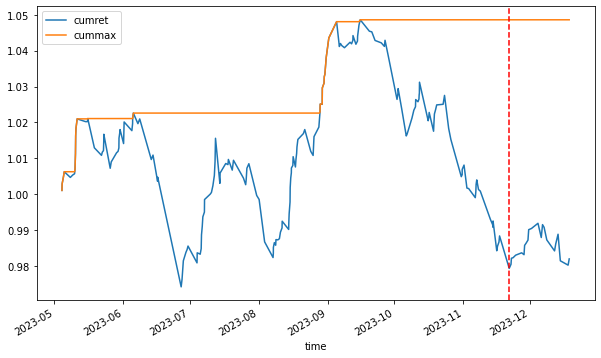

In [209]:
mean_ret = strategy_test_data[['pos_val_']].mean().apply(np.exp)
std_ret =  strategy_test_data[['pos_val_']].std().apply(np.exp)

# Step 2: Calculate Sharpe ratio
#trading_days_per_year = 252  # Assuming daily data
risk_free_rate = 0.01
sharpe_ratio = (mean_ret - risk_free_rate /  std_ret)[0]

# Step 3: Calculate Calmar ratio
calmar_d= strategy_test_data.copy()
strategy_test_data['cumret'] = strategy_test_data['pos_val_'].cumsum().apply(np.exp)
strategy_test_data['cummax'] = strategy_test_data['cumret'].cummax()

strategy_test_data[['cumret', 'cummax']].dropna().plot(figsize=(10, 6))

drawdown = strategy_test_data['cummax'] - strategy_test_data['cumret']
maximum_drawdown = drawdown.max()

calmar_ratio = strategy_test_data['pos_val_'].mean()/abs(maximum_drawdown)

#Mark biggest drawdown
plt.axvline(drawdown.idxmax(), color='r', linestyle='--')
# Print Sharpe and Calmar ratios

#Longest drawdown
temp = drawdown[drawdown == 0]
periods = (temp.index[1:].to_pydatetime() - temp.index[:-1].to_pydatetime())
periods.max()

print("Sharpe Ratio:", sharpe_ratio)
print("Calmar Ratio:", calmar_ratio)
print("Longest drawdown period: ", periods.max())
print("Maximum drawdown: ", round(maximum_drawdown * 100, 2), "%")

In [186]:
# Predict on the testing set
y_pred = clf.predict(X_test)

In [179]:
def correct_strategy(row):
    strategy_p = row['p']
    profit = row['is_profit']
    if row['p']==1 and  row['is_profit'] == 0:
        row['p'] = -1

    elif row['p']== -1 and  row['is_profit'] == 0:
        row['p'] = 1
    return row

In [181]:
corrected_data = corr_strategy.loc[X_test.index].apply(correct_strategy, axis=1)

In [182]:
postion_corrected = corrected_data['p'].copy()

In [208]:
corrected_data['ret'] = np.log(X_test['2022-06-17 12:50:00':]['AUD_CAD'] / X_test['2022-06-17 12:50:00':]['AUD_CAD'].shift(1))
corrected_data.dropna(inplace=True)

corrected_data['pos_val'] = corrected_data['p'] * corrected_data['ret'] # Obliczanie stopy zwrortu Logm returns

#spread = 0.005
#trans_cost = spread / open_data['AUD_CAD'].mean()
trans_cost = 0.00012
corrected_data['pos_val_'] = np.where(corrected_data['p'].diff() != 0, corrected_data['pos_val'] - trans_cost, corrected_data['pos_val'])

#Cost for opening position
corrected_data['pos_val_'].iloc[0]  -= trans_cost

#Cost for closing opening position
corrected_data['pos_val_'].iloc[-1] -= trans_cost

sum_of_trades = len(corrected_data[corrected_data['p'].diff() != 0])

print('Return of pair AUD_CAD: ', "%.6f" % corrected_data[['ret']].sum().apply(np.exp)[0])
print('Return of corrected strategy: ', "%.6f" % corrected_data[['pos_val']].sum().apply(np.exp)[0])
print('Return of corrected strategy after transaction costs: ', "%.6f" % corrected_data[['pos_val_']].sum().apply(np.exp)[0])
print("Sum of trades: ", sum_of_trades)

Return of pair AUD_CAD:  0.988187
Return of strategy:  1.032854
Return of strategy after transaction costs:  1.017966
Sum of trades:  119


Sharpe Ratio Corrected: 0.9901122610893347
Calmar Ratio Corrected: 0.002420461199916433
Longest drawdown period Corrected:  69 days, 5:45:00
Maximum drawdown Corrected:  3.07 %


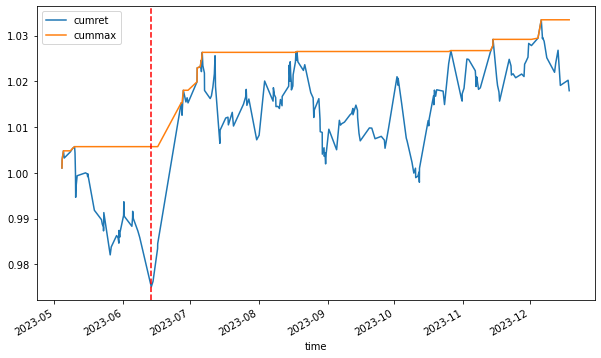

In [243]:
mean_ret = corrected_data[['pos_val_']].mean().apply(np.exp)
std_ret =  corrected_data[['pos_val_']].std().apply(np.exp)

# Step 2: Calculate Sharpe ratio
#trading_days_per_year = 252  # Assuming daily data
risk_free_rate = 0.01
sharpe_ratio = (mean_ret - risk_free_rate /  std_ret)[0]

# Step 3: Calculate Calmar ratio
calmar_d= corrected_data.copy()
corrected_data['cumret'] = corrected_data['pos_val_'].cumsum().apply(np.exp)
corrected_data['cummax'] = corrected_data['cumret'].cummax()

corrected_data[['cumret', 'cummax']].dropna().plot(figsize=(10, 6))

drawdown = corrected_data['cummax'] - corrected_data['cumret']
maximum_drawdown = drawdown.max()

calmar_ratio = corrected_data['pos_val_'].mean()/abs(maximum_drawdown)

#Mark biggest drawdown
plt.axvline(drawdown.idxmax(), color='r', linestyle='--')
# Print Sharpe and Calmar ratios

#Longest drawdown
temp = drawdown[drawdown == 0]
periods = (temp.index[1:].to_pydatetime() - temp.index[:-1].to_pydatetime())
periods.max()

print("Sharpe Ratio Corrected:", sharpe_ratio)
print("Calmar Ratio Corrected:", calmar_ratio)
print("Longest drawdown period Corrected: ", periods.max())
print("Maximum drawdown Corrected: ", round(maximum_drawdown * 100, 2), "%")

In [221]:
corrected_datas.columns = ['AUD_CAD', 'AUD_CAD_vol', 'BCO_USD', 'BCO_USD_vol', 'year', 'month',
       'day', 'hour', 'minute', 'second', 'day_of_week', 'return', 'roll_mean',
       'roll_mean_ret', 'roll_std', 'roll_std_ret', 'max', 'roll_max_ret',
       'max_l', 'min', 'roll_min_ret', 'min_l', 'exp_mavg', 'exp_mavg_l', 'ma',
       'mal', 'reg', 'quad_reg', 'rsi', 'ewma1', 'ewma2', 'p', 'ret',
       'pos_val', 'pos_val_corr', 'is_profit', 'cumret', 'cummax']

In [218]:
corrected_datas = corrected_data.copy()

<AxesSubplot:xlabel='time'>

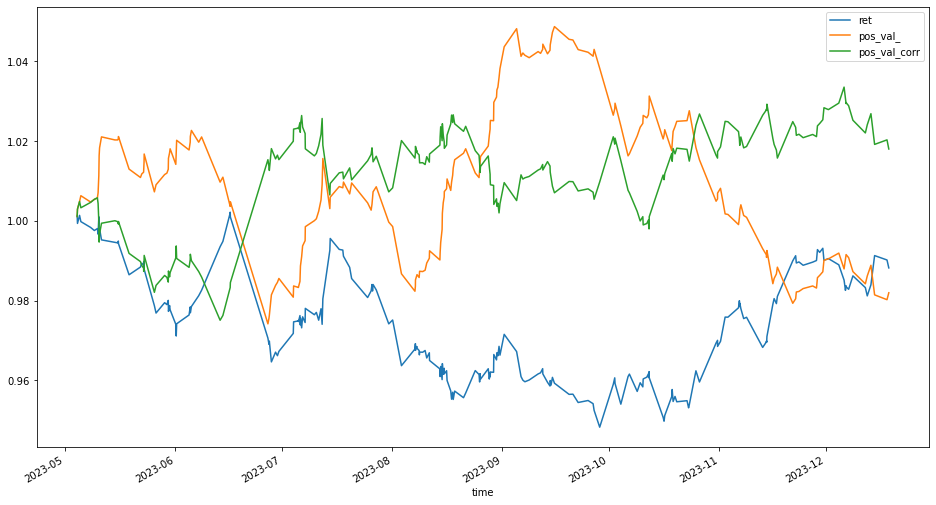

In [224]:
pd.merge(strategy_test_data[['ret','pos_val_']],corrected_datas['pos_val_corr'], on='time').cumsum().apply(np.exp).plot(figsize=(16,9)) 